In [24]:
import sys
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Notebook display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# Project root + ensure src on path
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.append(str(project_root / "src"))

In [25]:
from pathlib import Path
FULL = project_root / "data" / "US_Accidents_March23.csv"

if not FULL.exists():
    raise FileNotFoundError(f"Full CSV not found at {FULL}. Place full dataset there and retry.")

data_df = pd.read_csv(FULL, low_memory=False)
print("Done. data_df.shape =", data_df.shape)

Done. data_df.shape = (7728394, 46)


In [26]:
data_df.columns = [str(c).strip() for c in data_df.columns]

In [27]:
display(data_df.head(10))

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,Accident on I-270 Outerbelt Northbound near Ex...,Westerville Rd,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 07:51:00,37.9,35.5,97.0,29.63,7.0,SSW,3.5,0.03,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,Accident on Oakridge Dr at Woodward Ave. Expec...,N Woodward Ave,Dayton,Montgomery,OH,45417-2476,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,Accident on I-75 Southbound at Exit 54B Grand ...,N Main St,Dayton,Montgomery,OH,45405,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,Accident on Notre Dame Ave at Warner Ave. Expe...,Notre Dame Ave,Dayton,Montgomery,OH,45404-1923,US,US/Eastern,KFFO,2016-02-08 07:58:00,33.3,NaN,99.0,29.67,5.0,SW,1.2,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,Right hand shoulder blocked due to accident on...,Westerville Rd,Westerville,Franklin,OH,43081

In [28]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [29]:
display(data_df.describe(include=[np.number]).T)

,count,mean,std,min,25%,50%,75%,max
Severity,7728394.0,2.212384,0.487531,1.000000,2.000000,2.000000,2.000000,4.000000
Start_Lat,7728394.0,36.201195,5.076079,24.554800,33.399631,35.823974,40.084959,49.002201
Start_Lng,7728394.0,-94.702545,17.391756,-124.623833,-117.219396,-87.766616,-80.353676,-67.113167
End_Lat,4325632.0,36.261829,5.272905,24.566013,33.462070,36.183495,40.178920,49.075000
End_Lng,4325632.0,-95.725570,18.107928,-124.545748,-117.754345,-88.027890,-80.247086,-67.109242
Distance(mi),7728394.0,0.561842,1.776811,0.000000,0.000000,0.030000,0.464000,441.750000
Temperature(F),7564541.0,61.663286,19.013653,-89.000000,49.000000,64.000000,76.000000,207.000000
Wind_Chill(F),5729375.0,58.251048,22.389832,-89.000000,43.000000,62.000000,75.000000,207.000000
Humidity(%),7554250.0,64.831041,22.820968,1.000000,48.000000,67.000000,84.000000,100.000000
Pressure(in),7587715.0,29.538986,1.006190,0.000000,29.370000,29.860000,30.030000,58.630000


In [30]:
display(data_df.describe(include=[object]).T)

,count,unique,top,freq
ID,7728394,7728394,A-1,1
Source,7728394,3,Source1,4325632
Start_Time,7728394,6131796,2021-01-26 16:16:13,225
End_Time,7728394,6705355,2021-11-22 08:00:00,112
Description,7728389,3761578,A crash has occurred causing no to minimum del...,9593
Street,7717525,336306,I-95 N,78430
City,7728141,13678,Miami,186917
County,7728394,1871,Los Angeles,526851
State,7728394,49,CA,1741433
Zipcode,7726479,825094,91761,11247


In [31]:
missing_cnt = data_df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_cnt / len(data_df) * 100).round(3)
missing_df = pd.concat([missing_cnt, missing_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_percent']
print("=== Missingness top 30 ===")
display(missing_df.head(30))

=== Missingness top 30 ===


,missing_count,missing_percent
End_Lat,3402762,44.029
End_Lng,3402762,44.029
Precipitation(in),2203586,28.513
Wind_Chill(F),1999019,25.866
Wind_Speed(mph),571233,7.391
Visibility(mi),177098,2.292
Wind_Direction,175206,2.267
Humidity(%),174144,2.253
Weather_Condition,173459,2.244
Temperature(F),163853,2.120


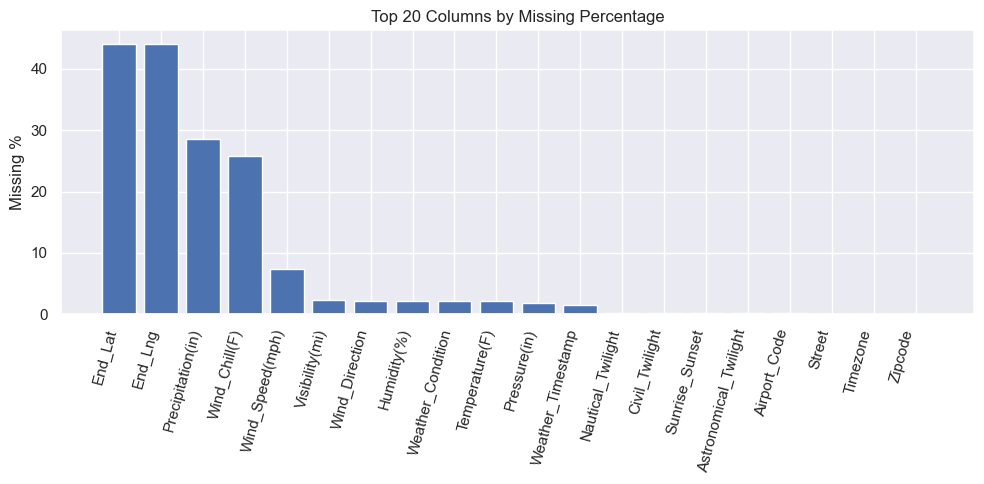

In [32]:
top_missing = missing_df.head(20)
plt.figure(figsize=(10,5))
plt.bar(top_missing.index.astype(str), top_missing['missing_percent'])
plt.xticks(rotation=75, ha='right')
plt.ylabel('Missing %')
plt.title('Top 20 Columns by Missing Percentage')
plt.tight_layout()
plt.show()

Detected target column: Severity


Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64

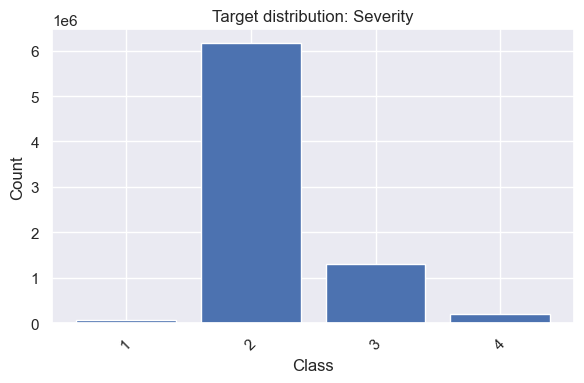

In [33]:
possible_targets = [c for c in data_df.columns if c.lower() in ('severity','severity_id','injury_severity','accident_severity')]
if len(possible_targets) > 0:
    target_col = possible_targets[0]
    print(f"Detected target column: {target_col}")
    vc = data_df[target_col].value_counts(dropna=False).sort_index()
    display(vc)
    plt.figure(figsize=(6,4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f'Target distribution: {target_col}')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    target_col = None
    print("No Severity-like target column detected. Will create or map a target later if needed.")